In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc({'font.size':22})

In [2]:
dt = 1/3000 #dt
t_Final= 2-1 # given in question 2s to 1s
numSamples = int(t_Final/dt) # training samples
starting_tstep= int(1/dt) # timestep corresponding to 1s
print(starting_tstep)
ending_tstep= int(2/dt) # timestep corresponding to 2s
print(f'Total number of training samples: {numSamples}')

3000
Total number of training samples: 3000


### Check the input files
placed inside folder called data

In [3]:
filename = "./data/Res06000.dat"
dummy_u = np.genfromtxt(filename, usecols=0, skip_header=1)
dummy_v = np.genfromtxt(filename, usecols=1, skip_header=1)
# check if files are read correctly
print(dummy_u)
print(dummy_v)
#load x and y grid data
filename = "./data/MESH.dat"
x_grid = np.genfromtxt(filename, usecols=0, skip_header=1)
y_grid = np.genfromtxt(filename, usecols=1, skip_header=1)
X,Y=np.meshgrid(x_grid,y_grid)
grid_size= x_grid.size * 2 # *2 because we need to stack u and v in a column
print(grid_size)
print(x_grid)
print(y_grid)


[9.574  9.6217 9.6217 ... 9.1632 9.1632 9.1632]
[-0.2097  -0.22091 -0.22091 ... -0.61266 -0.57319 -0.51827]
4260
[ 4.5551  5.431   6.3068 ... 64.112  64.988  65.864 ]
[-12.87  -12.87  -12.87  ...  12.529  12.529  12.529]


### Construct SVD Matrix and get modes
define function to construct velocity column such that order for given column is [u1,v1,u2,v2, .... u_N,v_N]^T

In [4]:
def uv_col(filename):
    """return u and v columns stacked (u1,v1,u2,v2,...) given a filename"""
    dummy_u = np.genfromtxt(filename, usecols=0, skip_header=1)
    dummy_v = np.genfromtxt(filename, usecols=1, skip_header=1)
    uv = [element for pair in zip(dummy_u, dummy_v) for element in pair] 
    return uv

def separate_uv(vel_time_block,column):
    """return u and v seperrated for column given an array whole columns correspond to timesteps and rows are u,v stacked"""
    return vel_time_block[::2,column],vel_time_block[1::2,column]

In [5]:
S = np.zeros((grid_size, numSamples))

#to construct SVD matrix S
#rows are arranged as u1,v1,u2,v2,...,uN,vN
#columns correspond to t1,t2,t3,...

for i in range(numSamples):
    filename = "./data/Res%05d.dat" % (i+starting_tstep) #now we start from t=1s
    S[:,i] = uv_col(filename)

#verify that matrix is correct
print(S)
print(S.shape)

[[12.343   12.628   12.55    ...  9.6857   9.809    9.5728 ]
 [-0.80145 -0.78099 -0.44459 ... -0.27481 -0.34457 -0.5315 ]
 [12.49    12.647   12.55    ...  9.6857   9.809    9.5657 ]
 ...
 [ 0.16501 -0.46392 -0.64501 ... -0.15632 -0.27762 -0.42447]
 [10.973   11.112   11.664   ...  8.724    8.6819   8.7709 ]
 [ 0.18202 -0.37328 -0.71983 ... -0.21013 -0.27762 -0.40863]]
(4260, 3000)


Generally I have seen POD is applied after mean is substracted, but problem does not say so, so I have not substracted mean.

In [6]:
# svd decomposition, U= spatial mode, VT= transpose of temporal mode, Sig= singular values
U, Sig, VT = np.linalg.svd(S, full_matrices=False)

# Reconstruction with 3 modes

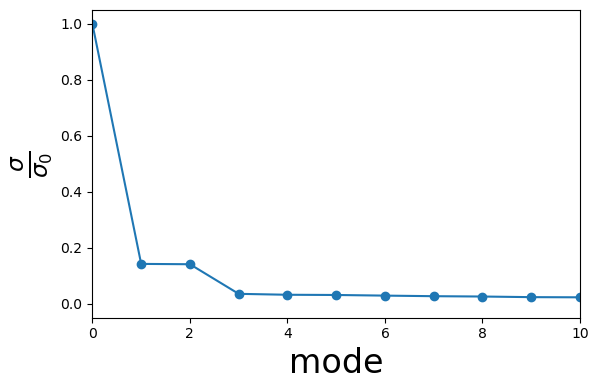

In [7]:
plt.rc('font', family='sans-serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb}')
plt.figure(figsize=(6,4))
plt.plot(Sig/Sig[0], '-o')
plt.xlabel('mode', fontsize=24)
plt.ylabel('$\\frac{\sigma}{\sigma_0}$', fontsize=24)
plt.tight_layout()
plt.xlim([0 ,10])
plt.savefig('modeVsTime2.png',dpi=600)

Now reconstruct for 3 modes

[25076.54818363  3571.92794127  3542.52431469]
True


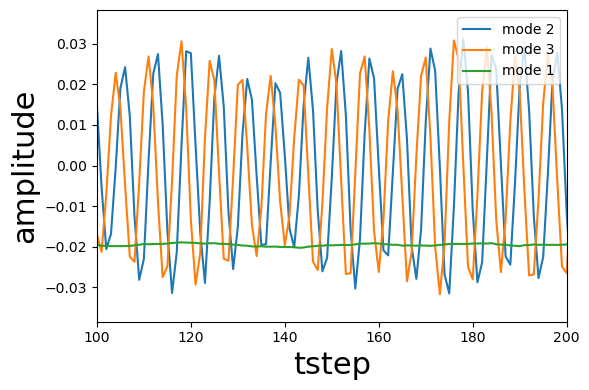

In [8]:
Sig_reduced = np.zeros(3)
Sig_reduced[:3] = Sig[:3]
VT_reduced = VT[:3, :]  #need this later also for RNN
U_reduced = U[:, :3]
print(Sig_reduced)

reconstructed_S_3_modes = U_reduced@np.diag(Sig_reduced)@VT_reduced#U @ np.diag(Sig_reduced) @ VT # or U[:,:3] @ np.diag(Sig[:3]) @ VT[:3,:]
print(np.isclose(U[:,:3] @ np.diag(Sig[:3]) @ VT[:3,:],reconstructed_S_3_modes,atol=1e-10).all())

# check eigenvalues for first 3 modes. Since we did not substract the mean, the first mode is similar to the mean flow (not exactly since it is time varying)
# mdoes 2 and 3 are complex conjugates of each other- same magnitude and opposite phase
# we can plot VT below to verify this
plt.figure(figsize=(6,4))

plt.plot(VT[1,:],label="mode 2")
plt.plot(VT[2,:],label="mode 3")
plt.plot(VT[0,:],label="mode 1")

#plt.legend(['mode1','mode 2', 'mode 3'], fontsize=10,loc='upper right')
plt.legend(fontsize=10,loc='upper right')
plt.xlabel('tstep', fontsize=22)
plt.ylabel('amplitude', fontsize=22)
plt.xlim([100,200]) # reduce clutter and better see the modes. Comment this to see the full picture
plt.tight_layout()
plt.savefig('VTvstsep2.png',dpi=600)


### Reconstruction error

mean error per timstep: 
[-0.05379722 -0.07378708 -0.06386066 ... -0.03694618 -0.04131392
 -0.03555222]
Percentage reconstruction error: 15.94116201953205 %


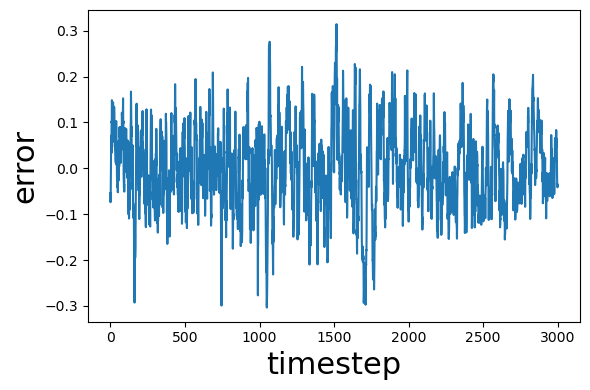

In [9]:
error_mean = np.mean(S-reconstructed_S_3_modes, axis=0) #avg accross all grid points for each timestep
print(f'mean error per timstep: \n{error_mean}')
error_percent = np.linalg.norm(S - reconstructed_S_3_modes)/np.linalg.norm(S)
print(f'Percentage reconstruction error: {error_percent*100} %')
plt.figure(figsize=(6,4))
plt.plot(error_mean, '-')
plt.xlabel('timestep', fontsize=22)
plt.ylabel('error', fontsize=22)
plt.tight_layout()
plt.savefig('errorVsTime2.png',dpi=600)

### Reconstructed flowfield

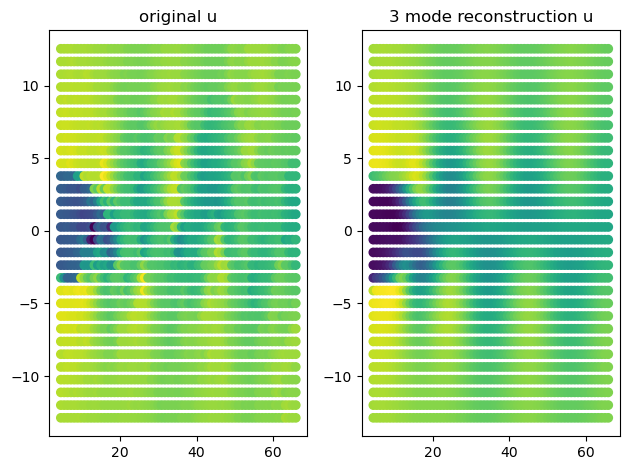

In [10]:
# origianl flow field and reconstructed flow field
time_sample= 20 # change this to see different timesteps
#NOTE this corresponds to 3020 timestep
u,v = separate_uv(S,time_sample)
u_recon,v_recon = separate_uv(reconstructed_S_3_modes,time_sample)
plt.subplot(1,2,1)
scatter = plt.scatter(x_grid, y_grid, c=u, cmap='viridis')
plt.title('original u')
plt.subplot(1,2,2)
scatter = plt.scatter(x_grid, y_grid, c=u_recon, cmap='viridis')
plt.title('3 mode reconstruction u')
plt.tight_layout()
plt.savefig('vel_reconst2.png',dpi=600)

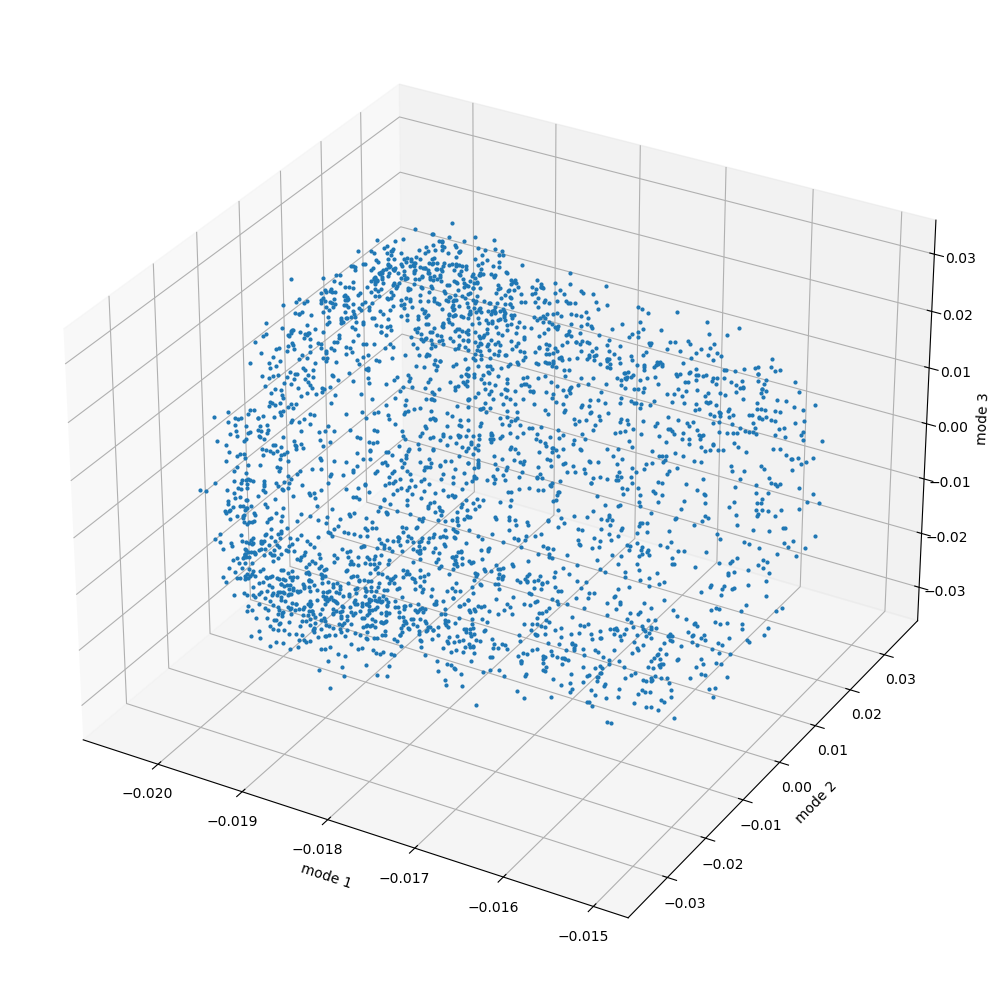

In [11]:
#plot 3d manifold using first 3 modes VT
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(VT[0,:], VT[1,:], VT[2,:], 'o', markersize=2)
ax.set_xlabel('mode 1')
ax.set_ylabel('mode 2')
ax.set_zlabel('mode 3')
plt.tight_layout()
plt.savefig('manifold_vt2.png',dpi=600)
# This does not look as good as the one done in the workshop. Possibly due to smaller time series data


Now we will make predition in this reduced dimensinal VT manifold and use U and \sigma to go back to full dimensional space
The row of this matrix correspond to modes and colomns corresponds to timesteps. So we take the matrix for first 3 modes and train for all the timesteps we have. Then we predict for next n timesteps and with the result, go back to full dimensional space to compare the results

### Define RNN

In [12]:
import torch
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(1234)
#torch.set_default_dtype(torch.float64) too slow
# Prepare data for RNN
def prep_train_target_sequence(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length]) # NOTE: i+seq_length is excluded 
        targets.append(data[i + seq_length])
        # targets.append(data[i + seq_length:i + seq_length + 1])
    return np.array(sequences), np.array(targets)

seq_length = 1500  #how long the seq length should be? #>>>>>>>>>>>>>>>>>>>>>>>> change me if needed
train, target = prep_train_target_sequence(VT_reduced.T, seq_length)

# Use torch dataloader for efficient loading
batch_size = 16 #>>>>>>>>>>>>>>>>>>>>>>>> change me if needed

train_tensor = torch.tensor(train, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.float32)
dataset = TensorDataset(train_tensor, target_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False) # shuffle=False since we want to keep the sequence


In [13]:
class RNNModel(torch.nn.Module):
    """
        Some notes below to avoid matrix errors
        https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        inputs: input, h0
        input:(N,L,H_in) or  batch_size, seq_len, input_size
        h0:(D(=1)*n_layers,N,H_out) or num_layers*num_directions, batch_size, hidden_size
        hidden:(D(=1)*n_layers,N,H_out) or num_layers*num_directions, batch_size, hidden_size
        Outputs: output, h_n
        output:(N,L,H_out*1) or batch_size, seq_len, hidden_size*num_directions
        h_n:(D(=1)*n_layers,N,H_out) or num_layers*num_directions, batch_size, hidden_size
    """
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, num_layers, nonlinearity='tanh', batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

input_dim = 3
hidden_dim = 32 #>>>>>>>>>>>>>>>>>>>>>>>> change me if needed
output_dim = 3

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RNNModel(input_dim, hidden_dim, output_dim).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #>>>>>>>>>>>>>>>>>>>>>>>> change me if needed

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Training loop starts here
num_epochs = 500 #>>>>>>>>>>>>>>>>>>>>>>>> change me if needed
loss_history = []

for epoch in range(num_epochs):
    for input_batch, target_batch in dataloader:

        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        
        output = model(input_batch)

        loss = loss_function(output, target_batch)
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
    
    loss_history.append(loss.item())
    if (epoch) % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')

# test loss -- possibly one could keep aside data of last few timestep from the training set and use that for test loss

Epoch [0/500], Loss: 0.00010713490337366238
Epoch [10/500], Loss: 1.6988057041089633e-06
Epoch [20/500], Loss: 1.6725308569220942e-06
Epoch [30/500], Loss: 2.06263325708278e-06
Epoch [40/500], Loss: 1.705159434095549e-06
Epoch [50/500], Loss: 1.8789011164699332e-06
Epoch [60/500], Loss: 2.359517111472087e-06
Epoch [70/500], Loss: 1.8546044202594203e-06
Epoch [80/500], Loss: 1.37486097173678e-06
Epoch [90/500], Loss: 1.172080374090001e-06
Epoch [100/500], Loss: 1.0389711633251864e-06
Epoch [110/500], Loss: 1.0154261644856888e-06
Epoch [120/500], Loss: 9.348129310637887e-07
Epoch [130/500], Loss: 9.084708381124074e-07
Epoch [140/500], Loss: 9.298935879087367e-07
Epoch [150/500], Loss: 9.508415246273216e-07
Epoch [160/500], Loss: 9.574411024004803e-07
Epoch [170/500], Loss: 9.017415436574083e-07
Epoch [180/500], Loss: 6.125812888058135e-07
Epoch [190/500], Loss: 6.055535095583764e-07
Epoch [200/500], Loss: 5.870240897820622e-07
Epoch [210/500], Loss: 5.983216055938101e-07
Epoch [220/500],

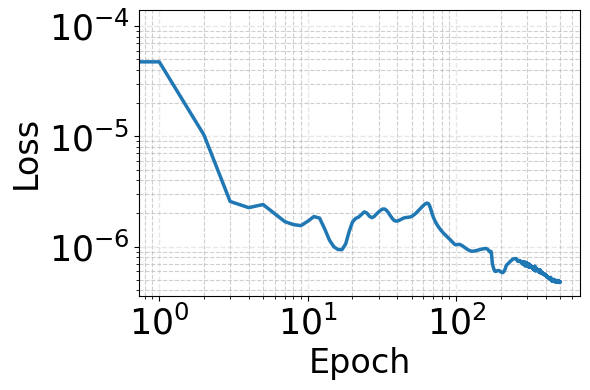

In [14]:
plt.rc('font', family='sans-serif')
#plt.rc('font', size=24)
plt.rc('ytick', labelsize=25)
plt.rc('xtick', labelsize=25)
plt.figure(figsize=(6,4))
plt.xticks(weight = 'medium')
plt.yticks(weight = 'medium')
plt.loglog(loss_history,linewidth=2.5)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Loss', fontsize=24)
plt.grid(True, linestyle='--',which='major', linewidth=1, alpha=0.3)
plt.grid(True, linestyle='--',which='minor', linewidth=0.8, alpha=0.6)
plt.minorticks_on()
#plt.ylim([1e-8,5e-6])
plt.tight_layout()
plt.savefig('lossVsEpoch2.png',dpi=600)

In [15]:
#  make N new predictions based on the previous prediction
# new prediction are added to the input sequence and used for next set of predictions
def generate_predictions(model, initial_input, num_predictions):
    model.eval() # We dont need backprop calc here 
    V_pred = [] # store data to automatically form the temporal eig vectors
    current_input = initial_input.unsqueeze(0)  # Add batch dim

    with torch.no_grad():
        for _ in range(num_predictions):
            current_input = current_input.to(device)
            prediction = model(current_input)
            V_pred.append(prediction.cpu().numpy())
            current_input = torch.cat((current_input[:, 1:, :], prediction.unsqueeze(1)), dim=1)  # ingesting the prediction as input for next prediction
    return np.array(V_pred)

initial_input = train_tensor[-1]  #take  last sequence from dataset as initial input
num_predictions = 3000  #num future predictions
V_pred = generate_predictions(model, initial_input, num_predictions)

V_pred = V_pred.squeeze() # Remove the batch dimension

print("Generated predictions in reduced space:")
# verify the shape of predictions is correct
print(V_pred.shape)
#new VT
VT_pred=V_pred.T
# now we will reconstruct the flow field using this predicted VT


Generated predictions in reduced space:
(3000, 3)


mean error per timstep: 
[-1.03869661 -1.05509065 -1.14971023 ...  0.10630969  0.09695175
  0.07367802]
Percentage prediction error: 30.69948102290932 %


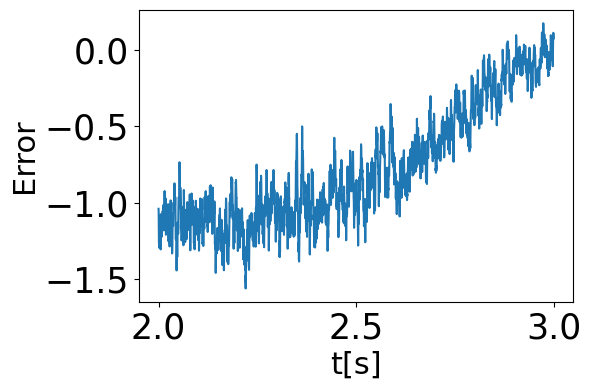

In [18]:
pred_S= U_reduced @np.diag(Sig_reduced)@ VT_pred # our predicted flowfield
true_S = np.zeros((grid_size, numSamples)) #actual data files that we have for future timesteps
for i in range(numSamples):
    filename = "./data/Res%05d.dat" % (i+1+starting_tstep) #since we need results starting from 1501 timestep to compare our predictions
    true_S[:,i] = uv_col(filename)

#reconstruction error
error_mean = np.mean(pred_S-true_S, axis=0) #avg accross all grid points for given timestep
print(f'mean error per timstep: \n{error_mean}')
error_percent = np.linalg.norm(pred_S-true_S)/np.linalg.norm(true_S)
print(f'Percentage prediction error: {error_percent*100} %')
plt.figure(figsize=(6,4))
plt.plot(np.linspace(2,3,3000),error_mean, '-')
plt.xlabel('t[s]', fontsize=22)
plt.ylabel('Error', fontsize=22)
plt.tight_layout()
plt.savefig('pred_error2.png',dpi=600)


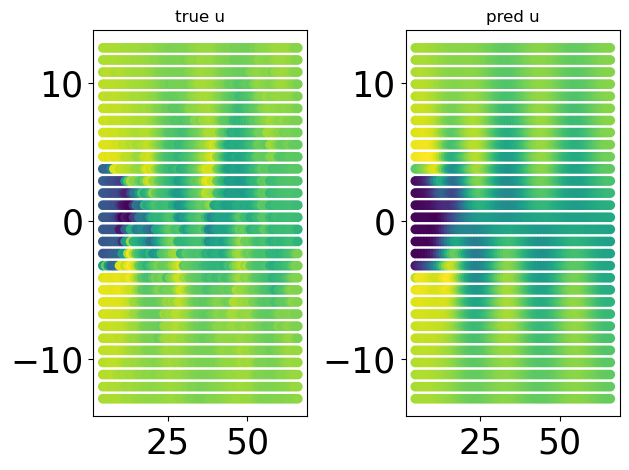

In [17]:
# true future unseen flow field and predicted flow field
time_sample= 20 #2500# change this to see different timesteps 
#NOTE: first column is 6001 timestep, so 20th column means 6020 timestep
u_true,v_true = separate_uv(true_S,time_sample)
u_pred,v_pred = separate_uv(pred_S,time_sample)
plt.subplot(1,2,1)
scatter = plt.scatter(x_grid, y_grid, c=u_true, cmap='viridis')
plt.title('true u')
plt.subplot(1,2,2)
scatter = plt.scatter(x_grid, y_grid, c=u_pred, cmap='viridis')
plt.title('pred u')
plt.tight_layout()
plt.savefig('predicted_vs_true2.png',dpi=600)